In [1]:
from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from scipy import stats

Using TensorFlow backend.


In [2]:
def get_data():
    path = "fastStorage/fastStorage/2013-8/1.csv"
    df = pd.read_csv(path, sep=';\t')
    df = df.drop(['CPU cores', 'Memory capacity provisioned [KB]'], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [3]:
def get_benchmark():
    path = "ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv"
    #path = "ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark_all.csv"
    df = pd.read_csv(path, sep=',')
    df = df.drop(['timestamp', 'is_anomaly'], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [4]:
def make_data_windows(data, window_length=12):
    train_windows = []
    for window_start in range(0, len(data) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(data[window_range])
        train_windows.append(window)
    return train_windows

In [5]:
def orchestrate_data(data, window_size, ltrain, lvalid, ltest):
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal = scaler.fit_transform(data)
    length = signal.shape[0]
    slicet = int(ltrain*(length))
    slicev = slicet + int(lvalid*(length))
    signal_train = signal[:slicet]
    signal_valid = signal[slicet:slicev]
    signal_test = signal[slicev:length]
    xtrain = np.array(make_data_windows(signal_train, window_size))
    xvalid = np.array(make_data_windows(signal_valid, window_size))
    xtest = np.array(make_data_windows(signal_test, window_size))
    return xtrain, xvalid, xtest

In [6]:
def modelgru(window_length, input_dim=1, hidden_dim=12):
    input_length = window_length
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(input_dim))
    m.compile(loss='mse', optimizer='adam')
    return m

In [7]:
def plot_reconstruction(history):
    plt.figure(figsize=(22, 4))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='best')
    plt.show()
    return

In [8]:
class model_lstm():
    def __init__(self, window_size, input_dim, hidden_dim):
        
        self.model = modelgru(window_size, input_dim, hidden_dim)
        self.window_size = window_size
        self.train_time = None
        self.treshold = None
        self.input_dim = input_dim
        self.checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5",
                                       verbose=1, save_best_only=True)
        self.earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        
    def train_model(self, x_train, x_valid, epochs):

        tbCallBack = TensorBoard(log_dir='lstm.autoencoder.tb.graph',
                                 histogram_freq=0, write_graph=True, write_images=True)

        start_time = time.time()
        history = self.model.fit(x_train, x_train, batch_size=self.window_size,
                                epochs=epochs, validation_data=(x_valid, x_valid), 
                                callbacks=[self.checkpointer, self.earlystopper, tbCallBack], verbose=0).history
        end_time = time.time()
        self.train_time = (end_time - start_time)/60
        plot_reconstruction(history)
        
        pred_x = self.model.predict(x_train)
        max_mae_of_predictions = np.squeeze(np.max(np.square(x_train[:,:,:] - pred_x[:,:,:]), axis=1))
        max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
        self.threshold = max_mae_threshold
        
        return history
    
    def train_batch(self, data, epochs, slicetr, slicev, slices):
        xtrain, xvalid, xtest = orchestrate_data(dataa, window_size, slicetr, slicev, slices)
        return instance.train_model(xtrain, xvalid, epochs) 
    
    def plot_scope(self, data):
        xtrain, xvalid, xtest = orchestrate_data(data, window_size, 1.0, 0.0, 0.0)
        predx = self.model.predict(xtrain)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        signal = scaler.fit_transform(data)
        
        if signal.shape[1] > 1:
            investigate_multi_errors(xtrain, predx, signal, self.window_size)
        else:
            investigate_errors(xtrain, predx, signal, self.window_size)
        return
              
    def predict(self, data):
        return self.model.predict(data)
    
    def update_threshold(self, data):
        xtrain, xvalid, xtest = orchestrate_data(data, window_size, 1.0, 0.0, 0.0)
        predx = self.model.predict(xtrain)
        
        max_mae_of_predictions = np.squeeze(np.max(np.square(xtrain[:, :, :] - predx[:, :, :]), axis=1))
        
        max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
        self.threshold = max_mae_threshold
        return
        
    def is_anomalous(self, data):
        y = np.reshape(np.array(data), (1, window_size, self.input_dim))
        pred = self.model.predict(y)
            #print(pred, y)
            #predicted hmm
            #max for each window is taken
            #avg for each window is taken
            #squeeze just eliminated redundant dimention of 1
            #max for each window we have and mean for each window we have
        max_mae = np.squeeze(np.max(np.square(y[:,:,:] - pred[:,:,:]), axis=1))

        if(self.threshold > max_mae):
            return "anomaly"
        else:
            return "benign"

In [9]:
def investigate_errors(x_test, pred_x_test, signal_test=None, window_length=None):
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], 
                  columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
    df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
    ax[0].set_title('max_mae_of_predictions distribution')
    df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
    df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1])
    ax[1].set_title('avg_mae_of_predictions distribution');
    kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
    kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)
    df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
    df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))
    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    
    plt.figure(figsize=(22, 4))
    df['max_mae_of_predictions'].plot()
    plt.axhline(y=max_mae_threshold, color='orange', label='threshold')
    plt.legend(loc='best')
    plt.title('max_mae_of_predictions_per_window')
    plt.grid(True, which='both');

    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    #print(pred_outlier_indices)
    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='red')
    plt.title('Anomalous Windows')
    plt.grid(True);

In [10]:
def investigate_multi_errors(x_test, pred_x_test, signal_test, window_length):
    
    #max for each window is taken
    #avg for each window is taken
    #squeeze just eliminated redundant dimention of 1
    #max for each window we have and mean for each window we have
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,:,:] - pred_x_test[:,:,:]), axis=1))
    
    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    #is your max error inside window greater than our threshold
    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    
    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
    plt.title('Anomalous Windows')

In [11]:
def get_data_actual():
    path = "mem.txt"
    df = pd.read_csv(path, sep=',', header=None)
    df = df.drop([0], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df


Epoch 00001: val_loss improved from inf to 0.00718, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.00718 to 0.00596, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00003: val_loss improved from 0.00596 to 0.00406, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00004: val_loss improved from 0.00406 to 0.00144, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00005: val_loss improved from 0.00144 to 0.00107, saving model to lstm.autoencoder.weights.best.hdf5


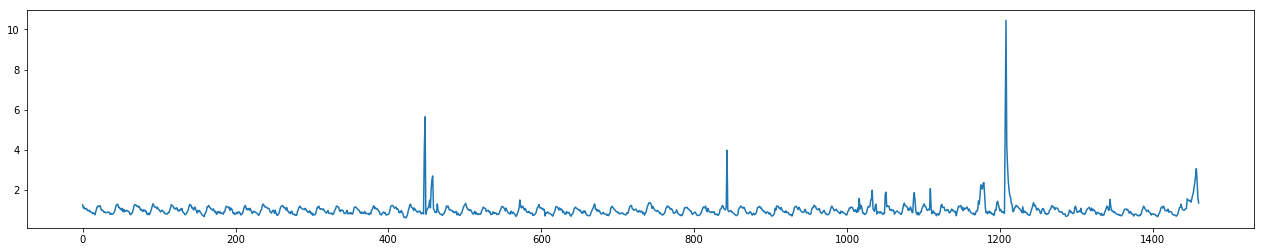

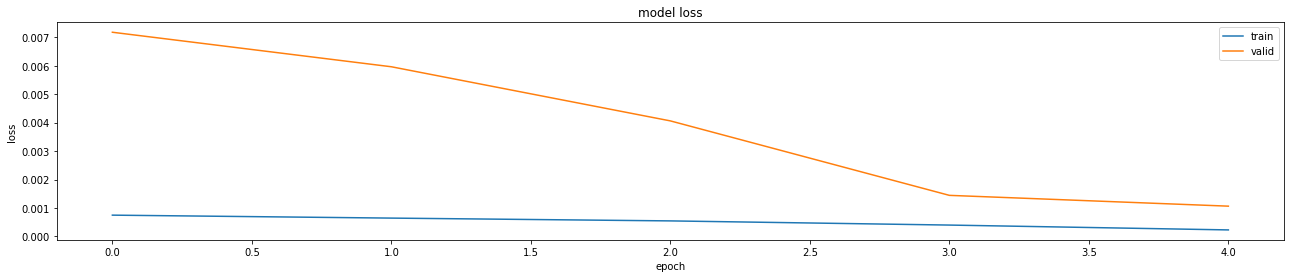

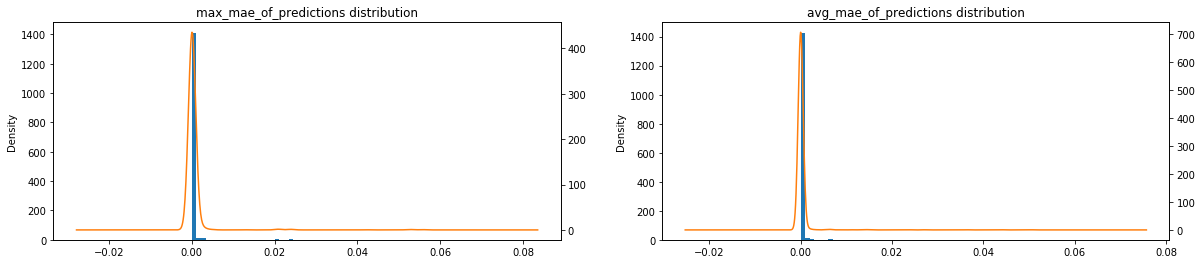

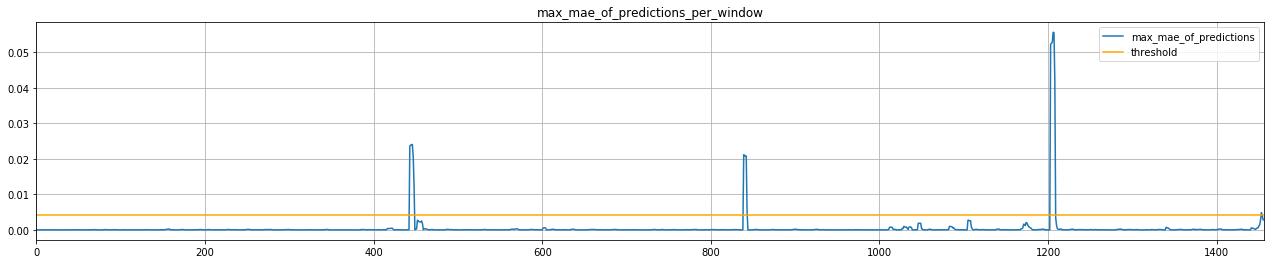

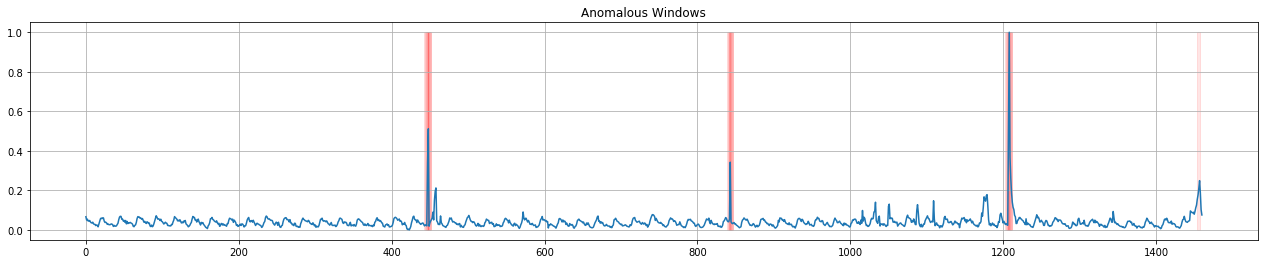

In [12]:
if __name__ == "__main__":
    window_size = 5
    input_dim = 1
    hidden_dim = 12
    instance = model_lstm(window_size, input_dim, hidden_dim)
    
    #dataa = get_data_actual()
    dataa = get_benchmark()
    plt.figure(figsize=(22, 4))
    plt.plot(dataa)
    
    xtrain, xvalid, xtest = orchestrate_data(dataa, window_size, 0.70, 0.15, 0.15)
    instance.train_model(xtrain, xvalid, 5)
    instance.plot_scope(dataa)

In [13]:
path = "ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_59.csv"
df = pd.read_csv(path, sep=',')
df = df.drop(['timestamp', 'is_anomaly'], 1)
if(df.isnull().sum().sum()):
    df = df.fillna(df.mean())


Epoch 00001: val_loss did not improve from 0.00107

Epoch 00002: val_loss did not improve from 0.00107

Epoch 00003: val_loss did not improve from 0.00107

Epoch 00004: val_loss did not improve from 0.00107

Epoch 00005: val_loss did not improve from 0.00107


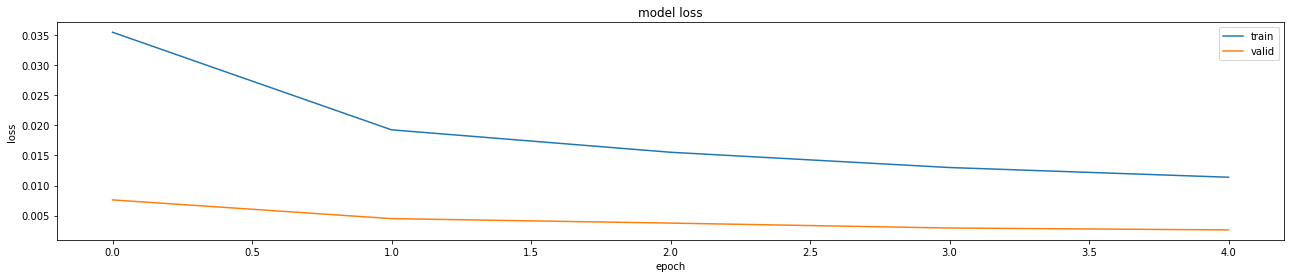

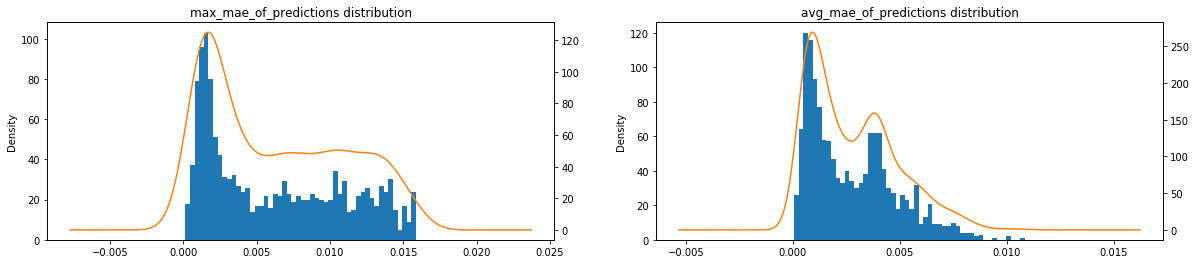

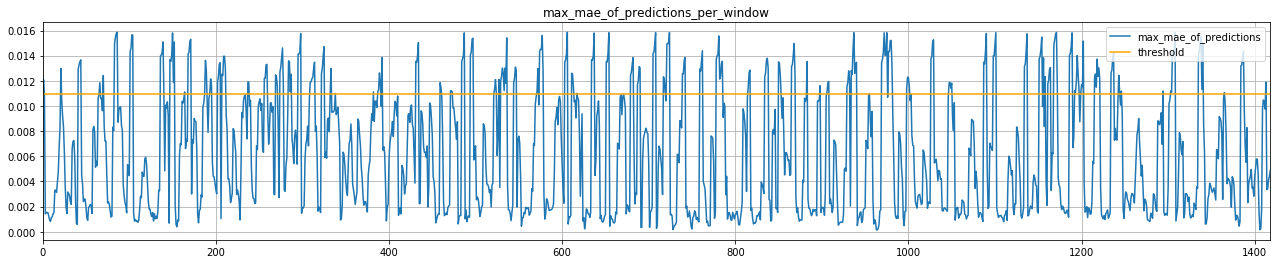

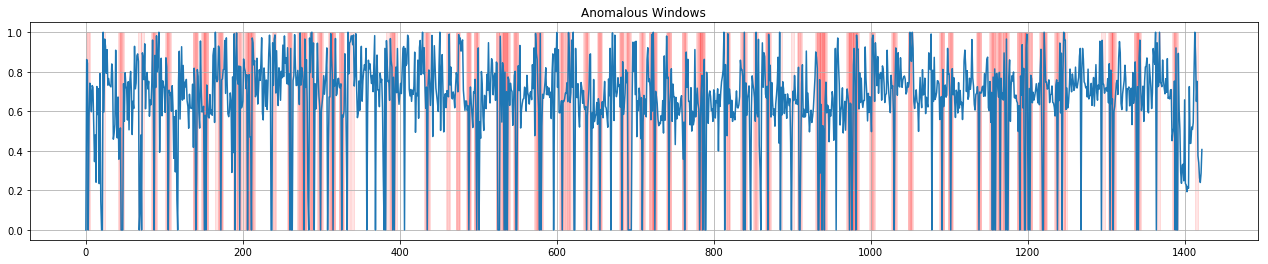

In [14]:
xtrain, xvalid, xtest = orchestrate_data(df, window_size, 0.70, 0.15, 0.15)
instance.train_model(xtrain, xvalid, 5)
instance.plot_scope(df)

In [17]:
input_dim = 1
window = []
for index, row in df.iterrows():
    item = row.values[0]
    if len(window) < 5:
        window.append(item)
        if len(window) == 5:
                print(item, instance.is_anomalous(window))
    else:
        #it was already 5
        #slide
        window.pop(0)
        window.append(item)
        #pred = instance.predict(item)
        print(item, instance.is_anomalous(window))
        continue

0.7423393782076301 benign
0.6997089531882 anomaly
0.59778871900906 anomaly
0.73022599945336 anomaly
0.72238025450536 anomaly
0.53254614092286 anomaly
0.34554597918255003 anomaly
0.48040511389261 anomaly
0.24121724789733998 anomaly
0.72544304552449 anomaly
0.5837409166928299 anomaly
0.71425568072783 anomaly
0.23415496519079998 anomaly
0.79074273233139 anomaly
0.14609425012014002 anomaly
0.0 anomaly
0.0 anomaly
1.0 anomaly
0.59709484328799 anomaly
0.9656336071428199 anomaly
0.92925236504345 benign
0.7922895676495001 anomaly
0.91182590832819 anomaly
0.73226302890425 anomaly
0.7660410088165501 anomaly
0.73386646590649 anomaly
0.72895405720478 anomaly
0.72363041554244 anomaly
0.83969793100979 anomaly
0.7948937432923001 anomaly
0.4590441721415999 anomaly
0.490601671975 anomaly
0.53418143652955 anomaly
0.9092748525609999 anomaly
0.59712941053577 anomaly
0.46543019182125 anomaly
0.6724222559909799 anomaly
0.35768329053811 anomaly
0.42371593800152 anomaly
0.51594693000745 anomaly
0.0 benign
0.0

0.8846694841219699 anomaly
0.70756080308395 anomaly
0.7091155820462499 anomaly
0.623331175944 anomaly
0.7928645838425301 anomaly
0.74919272971261 anomaly
0.76212225003088 anomaly
0.61520346387802 anomaly
0.26859376366582005 anomaly
0.0 anomaly
0.91829583405449 anomaly
0.0 anomaly
0.9576983409673699 anomaly
0.8363145961374799 anomaly
0.75008731748712 anomaly
0.75559291767425 anomaly
0.65533345624574 anomaly
0.96793338643453 anomaly
0.85488258403246 anomaly
0.8243694368071501 anomaly
0.0 anomaly
0.77256569555796 anomaly
0.0 benign
0.7100052769281999 anomaly
0.82371880064547 anomaly
0.6940043071202301 benign
0.917594722045 anomaly
0.6975543819663701 anomaly
0.63551171793142 anomaly
0.68532582340543 anomaly
0.74162820249421 anomaly
0.6896964778287901 anomaly
0.79718046888522 anomaly
0.91829583405449 anomaly
0.92769427110377 anomaly
0.0 anomaly
0.91829583405449 anomaly
0.8314203348384901 anomaly
0.84060472504268 anomaly
0.9850779776776201 anomaly
0.9705401490621701 anomaly
0.71143982142078 

0.60114461327771 benign
0.99985689915261 anomaly
0.6411955146187099 anomaly
0.0 benign
0.70109497329833 benign
0.6752412753720001 benign
0.6383721404475601 benign
0.5590067750534301 anomaly
0.52715626973555 anomaly
0.54310508525486 anomaly
0.53673629888206 anomaly
0.5782504420935699 anomaly
0.55402980385966 anomaly
0.6542358749276801 anomaly
0.49008709477587 anomaly
0.8802475148830999 anomaly
0.55504748257 anomaly
0.74234215763907 anomaly
0.98083403779614 anomaly
0.7664572819896999 anomaly
0.7725068857142601 anomaly
0.0 benign
0.63884505749211 benign
0.69476675479153 benign
0.81517405670875 benign
0.5492325458315099 anomaly
0.73792864639909 anomaly
0.6747542821536 anomaly
0.6735289326500401 anomaly
0.43180451187785 anomaly
0.67029748518009 anomaly
0.56172717681483 anomaly
0.64308645497977 anomaly
0.62116861230933 anomaly
0.58025349225115 anomaly
0.60642230370877 anomaly
0.66027029329335 anomaly
0.67918713808986 anomaly
0.54467103662673 anomaly
0.35814836544716 anomaly
0.5456338550099 a

0.61841226369438 anomaly
0.81069519565246 anomaly
0.68273341768748 anomaly
0.6871508853966 anomaly
0.76780328972057 anomaly
0.58830744976089 anomaly
0.6714031930260099 anomaly
0.6387672140666201 anomaly
0.6221082873782801 anomaly
0.8957541375001 anomaly
0.8690746665964301 anomaly
0.8112781244591301 anomaly
0.99107605983822 anomaly
0.0 anomaly
0.8080141510844498 anomaly
0.6500426973157399 anomaly
0.8730983020757701 anomaly
0.66011343253829 anomaly
0.6729481380502701 anomaly
0.6947823608133599 anomaly
0.75520245894466 anomaly
0.7522928918089001 anomaly
0.7377759102667 anomaly
0.55854882619704 anomaly
0.64362965334723 anomaly
0.6746133115587801 anomaly
0.0 benign
0.8120406807941 benign
0.62383791942336 benign
0.6969260739280799 benign
0.7331831596654399 anomaly
0.6713964459367902 anomaly
0.68217271013678 anomaly
0.91829583405449 anomaly
0.78969008214285 anomaly
0.78969008214285 anomaly
0.6643316545871301 anomaly
0.0 benign
0.72192809488736 benign
0.81597898233428 benign
0.68336915047821 b

0.78969008214285 anomaly
1.0 anomaly
0.8763576394898499 anomaly
0.65002242164835 anomaly
0.7514627759555501 anomaly
0.37494024493768996 anomaly
0.33981010556517 anomaly
0.2632603490545 anomaly
0.23992648037758 anomaly
0.28724418702747995 anomaly
0.40663827699304 anomaly
